In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
import statistics
from scipy.stats import mannwhitneyu

In [2]:
item = 'email' # Выбрать из поля Item для вашего датасета
package = 'openintro' # Выбрать из поля Package для вашего датасета

df = sm.datasets.get_rdataset(item, package , cache=True).data

In [3]:
#проверка на пропуски, пропуски отсутствуют.
df.isna().sum()

spam            0
to_multiple     0
from            0
cc              0
sent_email      0
time            0
image           0
attach          0
dollar          0
winner          0
inherit         0
viagra          0
password        0
num_char        0
line_breaks     0
format          0
re_subj         0
exclaim_subj    0
urgent_subj     0
exclaim_mess    0
number          0
dtype: int64

# Выберите две категориальные переменные и сформулируйте гипотезу об их взаимосвязи
# Гипотеза: письма, отмеченные как спам(spam = 1), содержат слово "срочно"(urgent_subj=1) в теме письма.

### Определяем частоту переменных spam и urgent_subj для теста ХИ-квадрат строим график

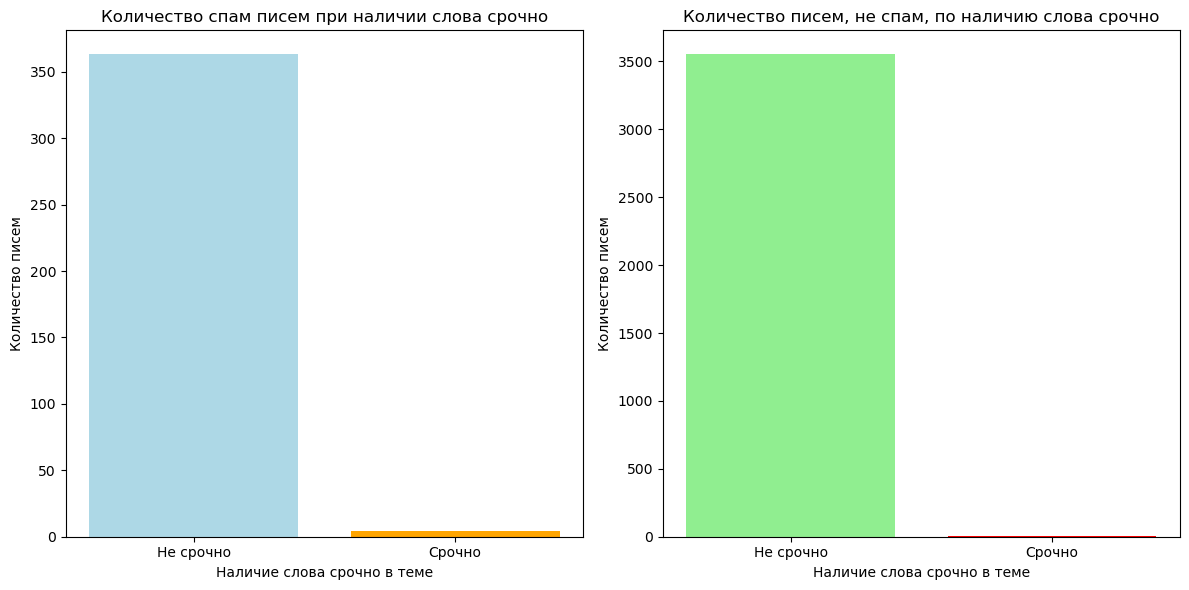

In [6]:
#пересечение переменных spam и urgent_subj, для подсчета колличества писем спама и не спама
df_hi = pd.crosstab(df['spam'], df['urgent_subj'], rownames=['Spam'], colnames=['Urgent'])
#посмотрим на графики, из за малого колличества данных, строим два графика
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
#распределение спама по наличию слова срочно
ax[0].bar(['Не срочно', 'Срочно'], df_hi.iloc[1], color=['lightblue', 'orange'])
ax[0].set_title('Количество спам писем при наличии слова срочно')
ax[0].set_ylabel('Количество писем')
ax[0].set_xlabel('Наличие слова срочно в теме')
#распределение не спама по наличию слова срочно
ax[1].bar(['Не срочно', 'Срочно'], df_hi.iloc[0], color=['lightgreen', 'red'])
ax[1].set_title('Количество писем, не спам, по наличию слова срочно')
ax[1].set_ylabel('Количество писем')
ax[1].set_xlabel('Наличие слова срочно в теме')
plt.tight_layout()
plt.show()

### Возможно письма с пометкой срочно чаще попадают в спам, чем письма без пометки срочно.

### Тест ХИ-квадрат

In [9]:
print('statistic =',stats.chi2_contingency(df_hi).statistic,'pvalue =',stats.chi2_contingency(df_hi).pvalue)
alpha = 0.05
print(np.where(stats.chi2_contingency(df_hi).pvalue < alpha , "Отвергаем нулевую гипотезу: что переменные spam и urgent_subj независимы", "Не отвергаем нулевую гипотезу: что переменные spam и urgent_subj зависимы"))

statistic = 13.651950624802293 pvalue = 0.0002200126393051727
Отвергаем нулевую гипотезу: что переменные spam и urgent_subj независимы


# Вывод: существует зависимость между переменными spam и urgent_subj. Письма с пометкой срочно чаще попадают в спам.

# Выберите одну категориальную и одну числовую переменную и сформулируйте гипотезу об их взаимосвязи
# Гипотеза: Распределение количества символов (num_char) по признаку письма спам  или не спам, близкое к равному.

### Очистка от выбросов и пропусков

In [13]:
df['num_char'].describe()

count    3921.000000
mean       10.706586
std        14.645786
min         0.001000
25%         1.459000
50%         5.856000
75%        14.084000
max       190.087000
Name: num_char, dtype: float64

### Переменная num_char имеет максимальное 190.087 количества символов, что указывает на возможные выбросы.

In [15]:
#Определяем интервал для выбросов для переменной exclaim_mess
q1 = df['num_char'].quantile(0.25)
q3 = df['num_char'].quantile(0.75)
iqr = q3 - q1
lowr_bound_num_char = round((q1 - 1.5*iqr),2)
upper_bound_num_char = round((q3 + 1.5*iqr),2)
print (f'Выбросами будут считаться все письма, в которых колличество символов находится за пределами интервала [{lowr_bound_num_char},{upper_bound_num_char}]')

Выбросами будут считаться все письма, в которых колличество символов находится за пределами интервала [-17.48,33.02]


In [16]:
#убарл выбросы
df_ejection_shapiro=df[(df['num_char']>=lowr_bound_num_char)&(df['num_char']<=upper_bound_num_char)]

### Из переменных spam и num_char выделим две группы spam_group и non_spam_group строим график

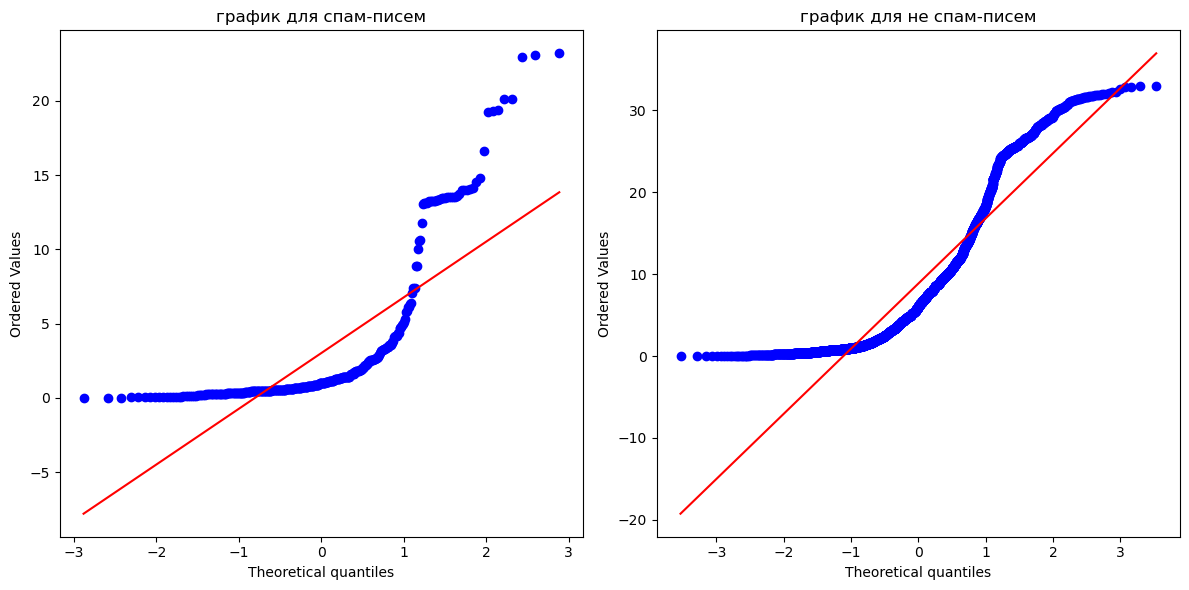

In [18]:
#выделим две группы spam_chars и not_spam_chars
spam_group = df_ejection_shapiro[df_ejection_shapiro['spam'] == 1]['num_char']
non_spam_group = df_ejection_shapiro[df_ejection_shapiro['spam'] == 0]['num_char']
#проверка на нормальность распределение перменных
plt.figure(figsize=(12, 6))
#график для спам писем
plt.subplot(1, 2, 1)
stats.probplot(spam_group, dist="norm", plot=plt)
plt.title('график для спам-писем')
#график для писем не спам
plt.subplot(1, 2, 2)
stats.probplot(non_spam_group, dist="norm", plot=plt)
plt.title('график для не спам-писем')
plt.tight_layout()
plt.show()

### Распределение не похоже на нормальное распределение, хвосты графика сильно отходят от линии.

### Тест Шапиро-Уилка для проверки на нормальное распределение

In [21]:
alpha = 0.05
print(np.where( stats.shapiro(spam_group).pvalue<alpha,'для переменной spam_group отвергаем нулевую гипотезу: распределение не соответствует нормальному', 'для переменной spam_group не отвергаем нулевую гипотезу: распределение нормальное'))
print(np.where( stats.shapiro(non_spam_group).pvalue<alpha,'для переменной non_spam_group отвергаем нулевую гипотезу: распределение не соответствует нормальному', 'для переменной non_spam_group не отвергаем нулевую гипотезу: распределение нормальное'))

для переменной spam_group отвергаем нулевую гипотезу: распределение не соответствует нормальному
для переменной non_spam_group отвергаем нулевую гипотезу: распределение не соответствует нормальному


### Тест Манна-Уитни для проверки гипотезы: Распределение количества символов (num_char) по признаку письма спам  или не спам, близкое к равному.

In [24]:
print(np.where(stats.mannwhitneyu(spam_group, non_spam_group, alternative='two-sided').pvalue<alpha,'Отвергаем нулевую гипотезу: есть статистически значимая разница между группами.','Не можем отвергнуть нулевую гипотезу: нет статистически значимой разницы между группами.'))

Отвергаем нулевую гипотезу: есть статистически значимая разница между группами.


In [26]:
#сравниваем медианы для окончательного вывода
print(np.where(spam_group.median()<non_spam_group.median(),'спам-письма имеют меньшее количеством символов', 'письма не спам имеют меньшее количеством символов'))

спам-письма имеют меньшее количеством символов


# Вывод: Распределение между двумя группами (спам и не спам по количеству символов) имеет различия. Есть вероятность, что письма с меньшим количеством чаще попадают в спам, чем письма с большим количеством символов.

# Выберите две числовые переменные и сформулируйте гипотезу об их взаимосвязи
# Гипотеза: Чем больше символов (num_char) в письме, тем больше восклицательных знаков (exclaim_mess) в сообщении.

In [30]:
df[['num_char', 'exclaim_mess']].describe()

,num_char,exclaim_mess
count,3921.000000,3921.000000
mean,10.706586,6.584290
std,14.645786,51.479871
min,0.001000,0.000000
25%,1.459000,0.000000
50%,5.856000,1.000000
75%,14.084000,4.000000
max,190.087000,1236.000000


### Переменная exclaim_mess имеет максимальное 1236 восклицательных знаков, что указывает на выбросы.

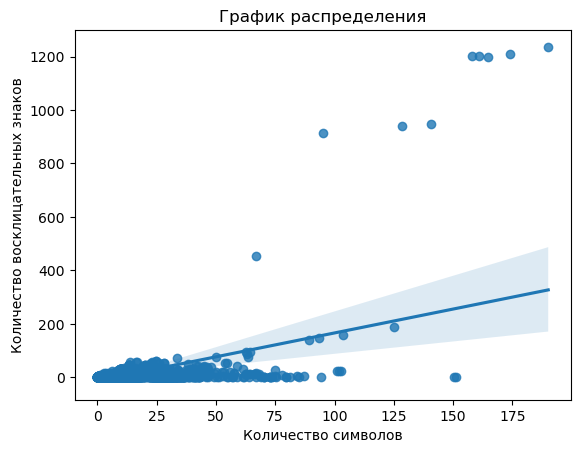

In [33]:
#график распределения 
sns.regplot(data=df, x='num_char', y='exclaim_mess')
plt.title('График распределения')
plt.xlabel('Количество символов')
plt.ylabel('Количество восклицательных знаков')
plt.show()

### На графике видны выбросы, тест Пирсона чувствителен к выбросам, делаю очистку.

### Очистка от выбросов и пропусков

In [37]:
#Определяем интервал для выбросов для переменной exclaim_mess
q1 = df['exclaim_mess'].quantile(0.25)
q3 = df['exclaim_mess'].quantile(0.75)
iqr = q3 - q1
lowr_bound_exclaim_mess = round((q1 - 1.5*iqr),2)
upper_bound_exclaim_mess = round((q3 + 1.5*iqr),2)
print (f'Выбросами будут считаться все письма, в которых колличество знаков "!" находится за пределами интервала [{lowr_bound_exclaim_mess},{upper_bound_exclaim_mess}]')

Выбросами будут считаться все письма, в которых колличество знаков "!" находится за пределами интервала [-6.0,10.0]


In [39]:
#убарл выбросы
df_ejection=df[(df['exclaim_mess']>=lowr_bound_exclaim_mess)&(df['exclaim_mess']<=upper_bound_exclaim_mess)]

In [41]:
#Определяем интервал для выбросов для переменной num_char
q1 = df['num_char'].quantile(0.25)
q3 = df['num_char'].quantile(0.75)
iqr = q3 - q1
lowr_bound_num_char = round((q1 - 1.5*iqr),2)
upper_bound_num_char = round((q3 + 1.5*iqr),2)
print (f'Выбросами будут считаться все письма, в которых колличество знаков находится за пределами интервала [{lowr_bound_num_char},{upper_bound_num_char}]')

Выбросами будут считаться все письма, в которых колличество знаков находится за пределами интервала [-17.48,33.02]


In [43]:
#убарл выбросы
df_ejection=df[(df['num_char']>=lowr_bound_num_char)&(df['num_char']<=upper_bound_num_char)]

### Корреляция Пирсона между num_char и exclaim_mess:

In [46]:
alpha = 0.05
print(np.where(stats.pearsonr(df_ejection['num_char'], df_ejection['exclaim_mess']).pvalue<alpha,'отвергаем нулевую гипотезу: подтверждаем наличие статистически значимой связи между переменными', 'не отвергаем нулевую гипотезу: отвергаем наличие статистически значимой связи между переменными'))

отвергаем нулевую гипотезу: подтверждаем наличие статистически значимой связи между переменными


In [48]:
print(' Коэффициент корреляции',stats.pearsonr(df_ejection['num_char'], df_ejection['exclaim_mess']).statistic, 'показывает умеренную положительную связь между переменными')

 Коэффициент корреляции 0.3742115506401589 показывает умеренную положительную связь между переменными


## Вывод: существует статистически значимая умеренная положительная связь между количеством символов и количеством восклицательных знаков. 
## Вероятней всего можно утверждать "чем больше символов (num_char) в письме, тем больше восклицательных знаков (exclaim_mess) в сообщении".

# Задача классификации: является ли электронное письмо спамом или не спамом 

### Практическое применение: автоматическая классификация входящих электронных письма как спам или не спам, повысит эффективность при фильтрации нежелательных сообщений

### Целевая переменная: spam принимает значения 1 — спам или 0 — не спам

### строим график для понимания, как распределяется переменная

In [55]:
#для красоты вывода считаем колличество значений, сбрасываем индекс, переводим переменную в str
target_spam = df['spam'].value_counts().reset_index()
target_spam['spam'] = target_spam['spam'].astype(str)
target_spam

,spam,count
0,0,3554
1,1,367


<BarContainer object of 2 artists>

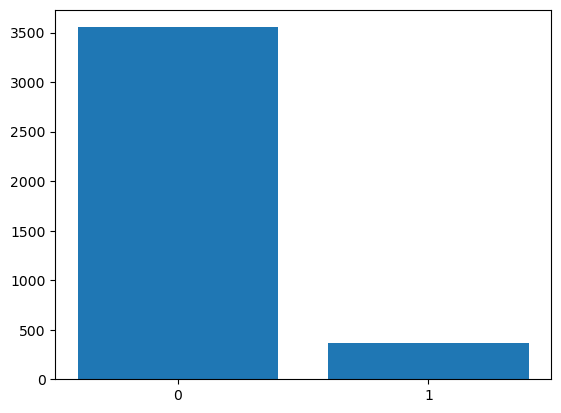

In [57]:
#выводим график
plt.bar(data = target_spam, x = 'spam', height = 'count')

### данных достаточно, чтобы провести обучение моделей

### На основе данных об электронных письмах мы пытаемся предсказать является ли письмо спамом или нет

### Выберем две переменны из наших данных об электронных письмах, на основание которых мы будем предсказывать вероятность

### Из первой части аттестации берем переменные
### num_char - количество символов в письме.
### urgent_subj - письмо содержит слово "срочно".

### проверим корреляцию между переменных

In [66]:
df['num_char'].corr(df['urgent_subj'])

-0.02331525305475056

### Корреляция между переменными указывает на слабую отрицательную связь, переменные можно включить в модель предсказания. Колличество символов в письме не зависит (крайне слабо зависит) от слова "срочно".

### очистка числовой переменной num_char

In [70]:
#Определяем интервал для выбросов для переменной num_char
q1 = df['num_char'].quantile(0.25)
q3 = df['num_char'].quantile(0.75)
iqr = q3 - q1
lowr_bound_num_char = round((q1 - 1.5*iqr),2)
upper_bound_num_char = round((q3 + 1.5*iqr),2)
print (f'Выбросами будут считаться все письма, в которых колличество символов находится за пределами интервала [{lowr_bound_num_char},{upper_bound_num_char}]')

Выбросами будут считаться все письма, в которых колличество символов находится за пределами интервала [-17.48,33.02]


In [72]:
#удалить выбросы
df=df[(df['num_char']>=lowr_bound_num_char)&(df['num_char']<=upper_bound_num_char)]

### Создаем матрицу переменных-предикторов (фичей) num_char + urgent_subj и вектор целевой переменной (таргет) spam

In [75]:
X = df[['num_char', 'urgent_subj']]
y = df['spam']

In [77]:
#импорт всех библиотек для создания, обучения и оценки модели
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV

### Разделите датасет на обучающую (60%) и тестовую (40%) выборки. Далее тестовую выборку разделите пополам (20% и 20%)

In [80]:
# X_train y_train обучающую (60%) и X_temp y_temp тестовую (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
# X_test_eval y_test_eval 20% качества и X_test_pred y_test_pred 20% прогноз
X_test_eval, X_test_pred, y_test_eval, y_test_pred = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### создаём модель KNeighborsClassifier

In [83]:
#создание
knn = KNeighborsClassifier(n_neighbors=3)
#обучение на 60%
knn.fit(X_train, y_train)
#прогноз на 20% качества
y_pred_knn = knn.predict(X_test_eval)

In [85]:
#оцениваем качество используя точность, плотность и матрицу ошибок
print("точность:", precision_score(y_test_eval, y_pred_knn))
print("плотность:", recall_score(y_test_eval, y_pred_knn))
print("матрица ошибок:\n", confusion_matrix(y_test_eval, y_pred_knn))

точность: 0.2972972972972973
плотность: 0.16666666666666666
матрица ошибок:
 [[651  26]
 [ 55  11]]


### Выводы:точность - 0.2973 только 29.73% писем действительно являются спамом, полнота - 0.1667 только 16.67% правильно идентифицированных писем как спам
### Качество модели — низкое, модель часто ошибается и пропускает спам письма.

In [88]:
#прогноз на 20% прогноз
y_pred_knn_final = knn.predict(X_test_pred)
print("прогноз модели:\n", y_pred_knn_final)

прогноз модели:
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0

### улучшение модели KNeighborsClassifier при помощи стандартизации

In [91]:
#создаём
scaler = StandardScaler()
#улучшаем 60% выборки 20% качества 20% прогноз
X_train_scaled = scaler.fit_transform(X_train)
X_test_eval_scaled = scaler.transform(X_test_eval)
X_test_pred_scaled = scaler.transform(X_test_pred)

In [93]:
#создание
knn_scaler = KNeighborsClassifier(n_neighbors=3)
#обучаем улучшуную модель на 60%
knn_scaler.fit(X_train_scaled, y_train)
#прогноз на 20% качества
y_pred_knn_scaler = knn_scaler.predict(X_test_eval_scaled)

In [95]:
#оцениваем качество улучшенной модели используя точность, плотность и матрицу ошибок
print("точность:", precision_score(y_test_eval, y_pred_knn_scaler))
print("плотность:", recall_score(y_test_eval, y_pred_knn_scaler))
print("матрица ошибок:\n", confusion_matrix(y_test_eval, y_pred_knn_scaler))

точность: 0.2972972972972973
плотность: 0.16666666666666666
матрица ошибок:
 [[651  26]
 [ 55  11]]


### Вывод: результаты после улучшения модели не изменился, качество модели - низкое, следует рассмотреть другие модели.

In [100]:
#прогноз на 20% прогноз
y_pred_knn_scaler_final = knn_scaler.predict(X_test_pred)
print("прогноз модели:\n", y_pred_knn_scaler_final)

прогноз модели:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0

### создаём модель DecisionTreeClassifier

In [103]:
#создание
dt = DecisionTreeClassifier(random_state=42)
#обучение на 60%
dt.fit(X_train, y_train)
#прогноз на 20% качества
y_pred_dt = dt.predict(X_test_eval)

In [105]:
#оцениваем качество используя точность, плотность и матрицу ошибок
print("точность:", precision_score(y_test_eval, y_pred_dt))
print("плотность:", recall_score(y_test_eval, y_pred_dt))
print("матрица ошибок:\n", confusion_matrix(y_test_eval, y_pred_dt))

точность: 0.2564102564102564
плотность: 0.30303030303030304
матрица ошибок:
 [[619  58]
 [ 46  20]]


### Выводы:точность - 0.2564 только 25.64% писем действительно являются спамом, полнота - 0.3030 только 30.30% правильно идентифицированных писем как спам
### Качество модели — низкое, результатов лучше, низкая точность говорит о возможности ложных срабатываний, что указывает на необходимость улучшения модели.

In [109]:
#прогноз на 20% прогноз
y_pred_dt_final = dt.predict(X_test_pred)
print("прогноз модели:\n", y_pred_dt_final)

прогноз модели:
 [0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 1 0

### улучшение модели DecisionTreeClassifier при помощи гиперпараметров

In [113]:
#подбираем гиперпараметры, перебрал много парамтров лучший результат оставил
param_grid = {'max_depth': [None, 30, 40, 50], 'min_samples_split': [5, 10, 15]}
#создаём
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
#обучаем на 60%
grid_search.fit(X_train, y_train)
best_dt = grid_search.best_estimator_
#прогноз на 20% качества
y_pred_best_dt = best_dt.predict(X_test_eval)

In [115]:
#оцениваем качество используя точность, плотность и матрицу ошибок
print("точность:", precision_score(y_test_eval, y_pred_best_dt))
print("плотность:", recall_score(y_test_eval, y_pred_best_dt))
print("матрица ошибок:\n", confusion_matrix(y_test_eval, y_pred_best_dt))

точность: 0.2923076923076923
плотность: 0.2878787878787879
матрица ошибок:
 [[631  46]
 [ 47  19]]


### Выводы:точность 0.2923 только 29.23% писем действительно являются спамом, полнота - 0.2878 только 28.78% правильно идентифицированных писем как спам
### Качество модели — низкое, результат указывает на улучшение точности, что уменьшит ложные срабатывания, но прирост не удовлетворительный.

In [118]:
#прогноз на 20% прогноз
y_pred_best_dt_final = best_dt.predict(X_test_pred)
print("прогноз модели:\n", y_pred_best_dt_final)

прогноз модели:
 [0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 1 0

### создаём модель RandomForestClassifier

In [121]:
#создание
rf = RandomForestClassifier(random_state=42)
#обучение на 60%
rf.fit(X_train, y_train)
#прогноз на 20% качества
y_pred_rf = rf.predict(X_test_eval)

In [123]:
#оцениваем качество улучшенной модели используя точность, плотность и матрицу ошибок
print("точность:", precision_score(y_test_eval, y_pred_rf))
print("плотность:", recall_score(y_test_eval, y_pred_rf))
print("матрица ошибок:\n", confusion_matrix(y_test_eval, y_pred_rf))

точность: 0.2597402597402597
плотность: 0.30303030303030304
матрица ошибок:
 [[620  57]
 [ 46  20]]


### Выводы:точность 0.2597 только 25.97% писем действительно являются спамом, полнота - 0.3030 только 30.30% правильно идентифицированных писем как спам
### Качество модели — низкая точность говорит о возможности ложных срабатываний, что указывает на необходимость улучшения модели.

In [126]:
#прогноз на 20% прогноз
y_pred_rf_final = rf.predict(X_test_pred)
print("прогноз модели:\n", y_pred_rf_final)

прогноз модели:
 [0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 1 0

### улучшение модели RandomForestClassifier при помощи гиперпараметров с трансформацией переменной (логарифм)

In [129]:
#создадим копию переменной-предиктора (фичи) num_char
X_train_rf = X_train.copy()
X_test_eval_rf = X_test_eval.copy()
X_test_pred_rf = X_test_pred.copy()

In [131]:
#трансформация переменной (логарифм)
X_train_rf['num_char'] = np.log1p(X_train_rf['num_char'])
X_test_eval_rf['num_char'] = np.log1p(X_test_eval_rf['num_char'])
X_test_pred_rf['num_char'] = np.log1p(X_test_pred_rf['num_char'])

In [133]:
#подбираем гиперпараметры, перебрал много парамтров лучший результат оставил
param_grid_rf = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [5, 10, 15, 20]}
#создаём
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5)  # 5-кратная кросс-валидация
#обучаем на 60%
grid_search_rf.fit(X_train_rf, y_train)
best_rf = grid_search_rf.best_estimator_ 
#прогноз на 20% качества
y_pred_best_rf = best_rf.predict(X_test_eval_rf)

In [134]:
print("точность:", precision_score(y_test_eval, y_pred_best_rf))
print("плотность:", recall_score(y_test_eval, y_pred_best_rf))
print("матрица ошибок:\n", confusion_matrix(y_test_eval, y_pred_best_rf))

точность: 0.32142857142857145
плотность: 0.13636363636363635
матрица ошибок:
 [[658  19]
 [ 57   9]]


### Выводы:точность 0.3214 только 32.14% писем действительно являются спамом, полнота - 0.1363 только 13.63% правильно идентифицированных писем как спам
### Качество модели — низкое, результат указывает на улучшение точности определения спам писем, но из-за низкой полноты много спам писем прейдёт пользователя

In [138]:
#прогноз на 20% прогноз
y_pred_best_rf_final = best_rf.predict(X_test_pred_rf)
print("прогноз модели:\n",y_pred_best_rf_final)

прогноз модели:
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 1 0

### создаём четвертую модель, перебрав все модели я выделил KNeighborsClassifier для классификации и попробую применим весь полученный опыт с новыми переменными.

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3715 entries, 0 to 3920
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   spam          3715 non-null   int64  
 1   to_multiple   3715 non-null   int64  
 2   from          3715 non-null   int64  
 3   cc            3715 non-null   int64  
 4   sent_email    3715 non-null   int64  
 5   time          3715 non-null   object 
 6   image         3715 non-null   int64  
 7   attach        3715 non-null   int64  
 8   dollar        3715 non-null   int64  
 9   winner        3715 non-null   object 
 10  inherit       3715 non-null   int64  
 11  viagra        3715 non-null   int64  
 12  password      3715 non-null   int64  
 13  num_char      3715 non-null   float64
 14  line_breaks   3715 non-null   int64  
 15  format        3715 non-null   int64  
 16  re_subj       3715 non-null   int64  
 17  exclaim_subj  3715 non-null   int64  
 18  urgent_subj   3715 non-null   int

In [143]:
#удалим переменные типа object и сохраним в новый датасет
df_4=df.drop(['time','winner','number'], axis=1)
df_4

,spam,to_multiple,from,cc,sent_email,image,attach,dollar,inherit,viagra,password,num_char,line_breaks,format,re_subj,exclaim_subj,urgent_subj,exclaim_mess
0,0,0,1,0,0,0,0,0,0,0,0,11.370,202,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,10.504,202,1,0,0,0,1
2,0,0,1,0,0,0,0,4,1,0,0,7.773,192,1,0,0,0,6
3,0,0,1,0,0,0,0,0,0,0,0,13.256,255,1,0,0,0,48
4,0,0,1,0,0,0,0,0,0,0,2,1.231,29,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3916,1,0,1,0,0,0,0,0,0,0,0,0.332,12,0,0,0,0,0
3917,1,0,1,0,0,0,0,1,0,0,0,0.323,15,0,0,0,0,0
3918,0,1,1,0,0,0,0,0,0,0,0,8.656,208,1,0,0,0,5
3919,0,1,1,0,0,0,0,0,0,0,0,10.185,132,0,0,0,0,0


In [145]:
#поиск переменных-предикторов (фичей) через корреляцию с целевой переменной spam
df_4.corr()['spam']

spam            1.000000
to_multiple    -0.109844
from           -0.087734
cc              0.003533
sent_email     -0.202852
image          -0.031318
attach          0.039273
dollar         -0.056880
inherit         0.026895
viagra          0.050640
password       -0.030816
num_char       -0.201609
line_breaks    -0.200038
format         -0.193792
re_subj        -0.178140
exclaim_subj    0.002443
urgent_subj     0.070588
exclaim_mess   -0.119578
Name: spam, dtype: float64

### самые подходящие переменные num_char -0.201609 и sent_email -0.202852 и line_breaks -0.200038, имеют сильную отрицательную корреляцию среди всех переменных относительно целевой переменной spam. Проверим корреляцию между переменными.

In [148]:
df_4['num_char'].corr(df_4['sent_email'])

-0.13194380529166783

### корреляция слабая отрицательная, нам не подходит. Скорей всего количество символов в письме и отправлено ли письмо за последние 30 дней не влияет на определения спам писем.

In [151]:
df_4['num_char'].corr(df_4['line_breaks'])

0.9493726237297727

### корреляция сильная положительная, подходит для обучения. Возможно есть зависимость между количеством символов в письме и количеством разрывов строк влияющая на определение спам писем. По моему мнению количество символов и количество разрывов в письмах лучше всего подходят для обучения модели.

In [154]:
#определение новых переменных-предикторов (фичей) num_char + sent_email  и целевой переменной spam для четвертой модели
X4 = df_4[['num_char', 'sent_email']]
y4 = df_4['spam']

In [156]:
# X_train_4 y_train_4 обучающую (60%) и X_temp_4 y_temp_4 тестовую (40%)
X_train_4, X_temp_4, y_train_4, y_temp_4 = train_test_split(X4, y4, test_size=0.4, random_state=42)
# X_test_eval_4 y_test_eval_4 20% качества и X_test_pred_4 y_test_pred_4 20% прогноз
X_test_eval_4, X_test_pred_4, y_test_eval_4, y_test_pred_4 = train_test_split(X_temp_4, y_temp_4, test_size=0.5, random_state=42)

### попытка улучшений логарифм, стандартизации и нормализации ухудшила результаты модели, поэтому не применялись.

In [159]:
#трансформация переменной (логарифм)
X_train_4_log1p = X_train.copy()
X_test_eval_4_log1p = X_test_eval.copy()
X_test_pred_4_log1p = X_test_pred.copy()
X_train_4_log1p['num_char'] = np.log1p(X_train_4['num_char'])
X_train_4_log1p['sent_email'] = np.log1p(X_train_4['sent_email'])
X_test_eval_4_log1p['num_char'] = np.log1p(X_test_eval_4['num_char'])
X_test_pred_4_log1p['num_char'] = np.log1p(X_test_pred_4['num_char'])
X_test_eval_4_log1p['sent_email'] = np.log1p(X_test_eval_4['sent_email'])
X_test_pred_4_log1p['sent_email'] = np.log1p(X_test_pred_4['sent_email'])
#при применени трансфформации переменных num_char и sent_email точность: 0.5 плотность: 0.1818

In [161]:
scaler = StandardScaler()
X_train_4_standardized = scaler.fit_transform(X_train_4)
X_test_eval_4_standardized = scaler.transform(X_test_eval_4)
X_test_pred_4_standardized = scaler.transform(X_test_pred_4)
#при применени стандартизации точность: 0.5 плотность: 0.197

In [163]:
min_max_scaler = MinMaxScaler()
X_train_4_normalized = min_max_scaler.fit_transform(X_train_4)
X_test_eval_4_normalized = min_max_scaler.transform(X_test_eval_4)
X_test_pred_4_normalized = min_max_scaler.transform(X_test_pred_4)
#при применени нормализации точность: 0.5 плотность: 0.197

### практика показала улучшение модели при помощи гиперпараметров лучше всего подходит.

In [166]:
#подбираем гиперпараметры, перебрал много парамтров лучший результат оставил
param_grid_4 = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 22, 25, 27, 29, 31, 33, 35], 'weights':['uniform', 'distance'],'metric': ['euclidean', 'manhattan']}
#создаём
grid_search_4 = GridSearchCV(estimator = KNeighborsClassifier(), param_grid=param_grid_4, scoring='accuracy', cv=5, n_jobs=-1)
#обучаем на 60%
grid_search_4.fit(X_train_4 , y_train_4)
best_4 = grid_search_4.best_estimator_ 
#grid_search_4.fit(X_train_4_standardized , y_train_4) #попытка стандартизации
#grid_search_4.fit(X_train_4_normalized , y_train_4) #попытка нормализации
#grid_search_4.fit(X_train_4_log1p , y_train_4) #попытка трансформации переменной
#прогноз на 20% качества
y_pred_best_4 = best_4.predict(X_test_eval_4)
#y_pred_best_4 = grid_search_4.predict(X_test_eval_4_standardized) #попытка стандартизации
#y_pred_best_4 = grid_search_4.predict(X_test_eval_4_normalized) #попытка нормализации
#y_pred_best_4 = grid_search_4.predict(X_test_eval_4_log1p) #попытка трансформации переменной

In [168]:
# Оценка качества лучшей модели Random Forest для четвертой модели
print("точность:", precision_score(y_test_eval_4, y_pred_best_4))  # Вычисляем точность
print("плотность:", recall_score(y_test_eval_4, y_pred_best_4))  # Вычисляем полноту
print("матрица ошибок:\n", confusion_matrix(y_test_eval_4, y_pred_best_4))  # Создаем матрицу ошибок
print("при параметрах:", grid_search_4.best_params_)
print("при кросс-валидации:", grid_search_4.best_score_)

точность: 0.5384615384615384
плотность: 0.21212121212121213
матрица ошибок:
 [[665  12]
 [ 52  14]]
при параметрах: {'metric': 'euclidean', 'n_neighbors': 21, 'weights': 'uniform'}
при кросс-валидации: 0.908931324633446


### Выводы:точность 0.5384 только 53.84% писем действительно являются спамом, полнота - 0.2121 только 21.21% правильно идентифицированных писем как спам
### Качество модели — удовлетворительно, результатов указывает на малую долю ошибок, что говорит о малом количестве ложных срабатываний, но есть вероятность получение пользователем спам писем.

In [171]:
#прогноз на 20% прогноз
y_pred_best_4_final = best_4.predict(X_test_pred_4)
print("прогноз модели:\n",y_pred_best_4_final)

прогноз модели:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 1 0

### сравним модели для выбора лучшей

### y_pred_knn предсказания KNeighborsClassifier
### y_pred_knn_scaler предсказания улучшенного KNeighborsClassifier
### y_pred_dt предсказания DecisionTreeClassifier
### y_pred_best_dt предсказания улучшенного DecisionTreeClassifier
### y_pred_rf предсказания RandomForestClassifier
### y_pred_best_rf предсказания улучшенного RandomForestClassifier
### y_pred_best_4 предсказания улучшенного KNeighborsClassifier

### соберем все данные

In [178]:
df_all = pd.DataFrame([
    ('KNeighborsClassifier', y_pred_knn),
    ('KNeighborsClassifier_up', y_pred_knn_scaler),
    ('DecisionTreeClassifier', y_pred_dt),
    ('DecisionTreeClassifier_up', y_pred_best_dt),
    ('RandomForestClassifier', y_pred_rf),
    ('RandomForestClassifier_up', y_pred_best_rf),
    ('KNeighborsClassifier_up_end', y_pred_best_4)
], columns=['model', 'results'])

In [180]:
df_all

,model,results
0,KNeighborsClassifier,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,KNeighborsClassifier_up,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,DecisionTreeClassifier,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,DecisionTreeClassifier_up,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,RandomForestClassifier,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,RandomForestClassifier_up,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,KNeighborsClassifier_up_end,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### создадим функцию пересчета всех известных оценок качества моделей

In [183]:
def quality_all(y_orig, y_pred):
    return {
        'Accuracy': accuracy_score(y_orig, y_pred),
        'Precision': precision_score(y_orig, y_pred),
        'Recall': recall_score(y_orig, y_pred),
        'F1 Score': f1_score(y_orig, y_pred),
        'ROC AUC': roc_auc_score(y_orig, y_pred)
    }

### запишем оценки качества в датасет

In [186]:
for index in df_all.index:
    results = df_all.loc[index, 'results']
    quality_metrics = quality_all(y_test_eval, results)
    df_all.loc[index, 'Accuracy'] = quality_metrics['Accuracy']
    df_all.loc[index, 'Precision'] = quality_metrics['Precision']
    df_all.loc[index, 'Recall'] = quality_metrics['Recall']
    df_all.loc[index, 'F1 Score'] = quality_metrics['F1 Score']
    df_all.loc[index, 'ROC AUC'] = quality_metrics['ROC AUC']

In [188]:
df_all

,model,results,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,KNeighborsClassifier,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.890983,0.297297,0.166667,0.213592,0.564131
1,KNeighborsClassifier_up,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.890983,0.297297,0.166667,0.213592,0.564131
2,DecisionTreeClassifier,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.860027,0.256410,0.303030,0.277778,0.608679
3,DecisionTreeClassifier_up,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.874832,0.292308,0.287879,0.290076,0.609966
4,RandomForestClassifier,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.861373,0.259740,0.303030,0.279720,0.609418
5,RandomForestClassifier_up,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.897712,0.321429,0.136364,0.191489,0.554149
6,KNeighborsClassifier_up_end,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.913863,0.538462,0.212121,0.304348,0.597198


### Вывод: по моему мнению последняя четвертая модель KNeighborsClassifier_up показала лучшие результаты
### Точность 53.8% лучше всех классифицирует письмо как спам
### Полнота 21.2% близкая к среднему показателю риска получения спам писем из всех моделей

### соберем все данные по второй части тестовой выборки 20% прогноз 
### Предполагается, что здесь значения таргета нам неизвестны – как в практической ситуации использования моделей прогнозирования.

### y_pred_knn_final предсказания KNeighborsClassifier
### y_pred_knn_scaler_final предсказания улучшенного KNeighborsClassifier
### y_pred_dt_final предсказания DecisionTreeClassifier
### y_pred_best_dt_final предсказания улучшенного DecisionTreeClassifier
### y_pred_rf_final предсказания RandomForestClassifier
### y_pred_best_rf_final предсказания улучшенного RandomForestClassifier
### y_pred_best_4_final предсказания улучшенного KNeighborsClassifier

In [193]:
df_all_final = pd.DataFrame([
    ('KNeighborsClassifier', y_pred_knn_final),
    ('KNeighborsClassifier_up', y_pred_knn_scaler_final),
    ('DecisionTreeClassifier', y_pred_dt_final),
    ('DecisionTreeClassifier_up', y_pred_best_dt_final),
    ('RandomForestClassifier', y_pred_rf_final),
    ('RandomForestClassifier_up', y_pred_best_rf_final),
    ('KNeighborsClassifier_up_end', y_pred_best_4_final)
], columns=['model', 'results'])

In [195]:
df_all_final

,model,results
0,KNeighborsClassifier,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
1,KNeighborsClassifier_up,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,DecisionTreeClassifier,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ..."
3,DecisionTreeClassifier_up,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ..."
4,RandomForestClassifier,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ..."
5,RandomForestClassifier_up,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
6,KNeighborsClassifier_up_end,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [197]:
for index in df_all_final.index:
    count_0 = np.sum(df_all_final.iloc[index]['results'] == 0)
    count_1 = np.sum(df_all_final.iloc[index]['results'] == 1)
    df_all_final.loc[index, 'not_spam'] = count_0
    df_all_final.loc[index, 'spam'] = count_1
    

In [199]:
df_all_final

,model,results,not_spam,spam
0,KNeighborsClassifier,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",704.0,39.0
1,KNeighborsClassifier_up,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",741.0,2.0
2,DecisionTreeClassifier,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",671.0,72.0
3,DecisionTreeClassifier_up,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",674.0,69.0
4,RandomForestClassifier,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",668.0,75.0
5,RandomForestClassifier_up,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",715.0,28.0
6,KNeighborsClassifier_up_end,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",718.0,25.0


### Вывод: Учитывая предсказания у которых значения таргета нам неизвестны можно сказать, чтоб модель KNeighborsClassifier_up меньше всего, будет ошибаться в определении простых писем как спам. Модели  KNeighborsClassifier_up_end и RandomForestClassifier_up показывают хорошие результаты в определение не спама и относительно низкие результаты по определению спам писем. Мои рекомендации использовать модель KNeighborsClassifier с улучшениями для повышения качества модели.